###1) Demonstrate by plotting original and reconstructed images that your model is performing well. You are free to chose your model configuration and any hyper-parameters.

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [3]:
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_accuracy, plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae
from helper_data import compute_average_faces
from helper_data import UnNormalize
from torch.utils.data import DataLoader
from helper_plotting import plot_modified_faces

In [4]:
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cuda:0


In [5]:
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def get_dataloaders_EuroSAT(batch_size, num_workers=0,
                           train_transforms=None,
                           test_transforms=None,
                           download=True):

    train_dataset = torchvision.datasets.EuroSAT(root='data',
                                    # target_transform=True,  
                                    transform=train_transforms,
                                    download=download)

    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)

    return train_loader

In [6]:
train_loader = get_dataloaders_EuroSAT(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    num_workers=2)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting data/eurosat/EuroSAT.zip to data/eurosat


In [7]:
torch.manual_seed(RANDOM_SEED)
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
EXAMPLE_IMAGE = images[1]

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256])


In [8]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
    

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [9]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [10]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                        save_model='vae_EuroSAT.pt')

Epoch: 001/050 | Batch 0000/0106 | Loss: 12125.1250
Epoch: 001/050 | Batch 0050/0106 | Loss: 5147.4321
Epoch: 001/050 | Batch 0100/0106 | Loss: 2271.6809
Time elapsed: 0.42 min
Epoch: 002/050 | Batch 0000/0106 | Loss: 1991.8756
Epoch: 002/050 | Batch 0050/0106 | Loss: 1058.7568
Epoch: 002/050 | Batch 0100/0106 | Loss: 746.0964
Time elapsed: 0.73 min
Epoch: 003/050 | Batch 0000/0106 | Loss: 670.4725
Epoch: 003/050 | Batch 0050/0106 | Loss: 512.4609
Epoch: 003/050 | Batch 0100/0106 | Loss: 400.0328
Time elapsed: 1.08 min
Epoch: 004/050 | Batch 0000/0106 | Loss: 404.9738
Epoch: 004/050 | Batch 0050/0106 | Loss: 362.4545
Epoch: 004/050 | Batch 0100/0106 | Loss: 311.7144
Time elapsed: 1.40 min
Epoch: 005/050 | Batch 0000/0106 | Loss: 299.9398
Epoch: 005/050 | Batch 0050/0106 | Loss: 271.2202
Epoch: 005/050 | Batch 0100/0106 | Loss: 295.6503
Time elapsed: 1.71 min
Epoch: 006/050 | Batch 0000/0106 | Loss: 260.7110
Epoch: 006/050 | Batch 0050/0106 | Loss: 234.2840
Epoch: 006/050 | Batch 0100/0

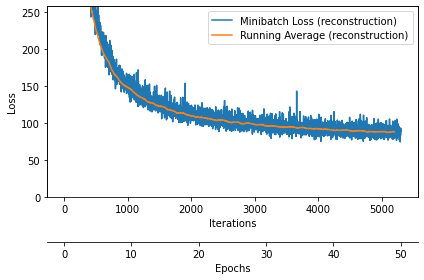

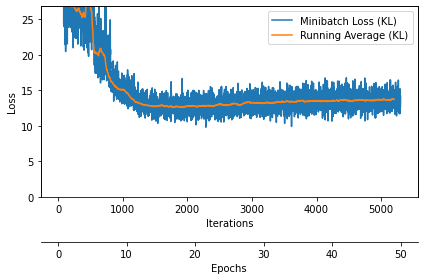

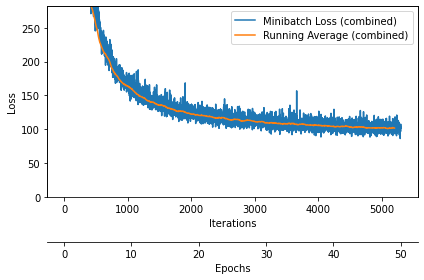

In [11]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

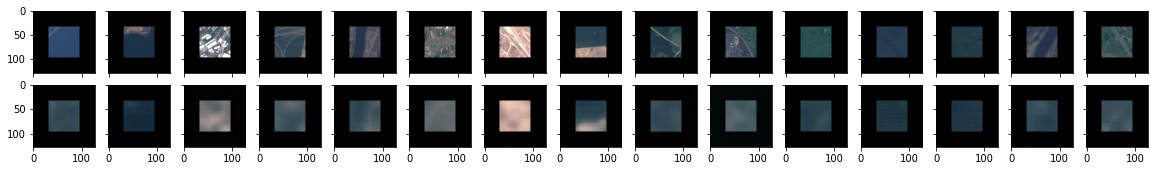

In [12]:
#unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')           

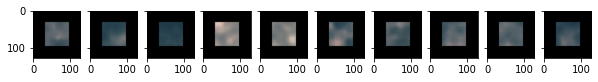

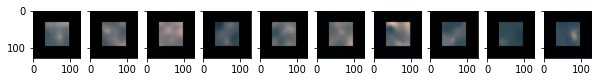

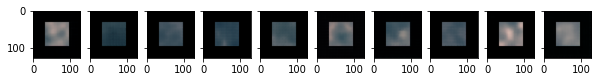

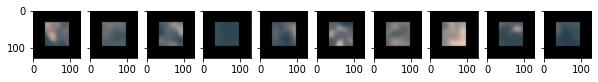

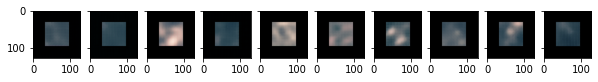

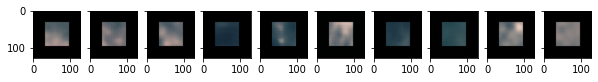

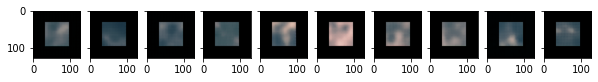

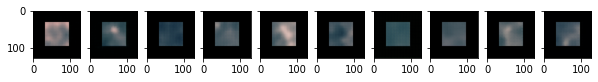

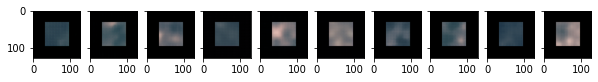

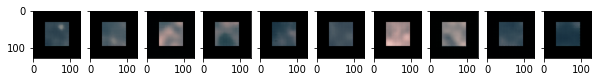

In [13]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=200)
    plt.show()

In [14]:
avg_img_with_industrial, avg_img_without_industrial = compute_average_faces(
    feature_idx=5,
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

In [15]:
avg_img_with_forest, avg_img_without_forest = compute_average_faces(
    feature_idx=2,
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

###2)Plot the reconstructed images from the mean of latent representations for 'industrial buildings'  and 'Forest' classes.

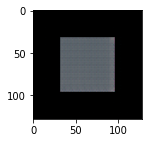

In [16]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(model.decoder(avg_img_with_forest.to(DEVICE)).squeeze().to('cpu').detach().permute(1,2,0))
plt.show()

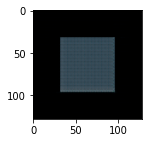

In [17]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(model.decoder(avg_img_with_industrial.to(DEVICE)).squeeze().to('cpu').detach().permute(1,2,0))
plt.show()

###3)Plot the transition from 'industrial buildings'  to 'Forest' by moving in the latent space from one class to another in 10 steps and generating the full images using the decoder.

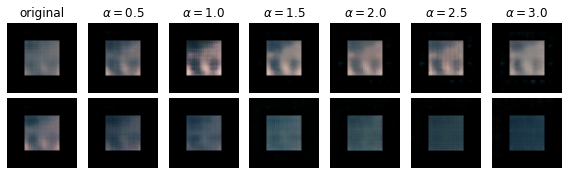

In [18]:
diff = (avg_img_with_forest - avg_img_with_industrial)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()